<a href="https://colab.research.google.com/github/m-barati/NLP_Shared_Task/blob/main/classic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####### IMPORTING AND DOWNLOADING THE NECESSARY LIBARARIES AND MODULES
import pandas as pd
import tensorflow as tf
import re
import numpy as np
import seaborn as sn
import csv
import os

import nltk
from nltk import word_tokenize, TweetTokenizer, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier 
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

from xgboost import XGBClassifier

!pip install emoji
import emoji 
!pip install textblob
import textblob
from textblob import TextBlob
!pip install -U symspellpy --quiet
from symspellpy import SymSpell
!wget https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

     |████████████████████████████████| 175 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f6076df8fb5c64364b15f12a8517a313d8aa8b303824d929c77708f6376dc974
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 2.6 MB 4.8 MB/s 
     |████████████████████████████████| 125 kB 43.8 MB/s 
--2022-05-05 21:17:41--  https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332879 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --

True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/ClassicModel/olid-training-v1.0.tsv'

In [ ]:
train = pd.read_csv(data_path, sep='\t')
train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [ ]:
def remove_noise(data):
  noise = '@USER'
  noise2 = '&amp'
  stops = set(stopwords.words('english'))
  eyes = '[8:=;]'
  nose = "['`\-~]"
  # remove URLs
  data['clean_tokens'] = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", "", tweet) for tweet in data['tweet']]
  # remove '@USER' and '&amp'
  data['clean_tokens'] = [tweet.replace(noise, '') for tweet in data['clean_tokens']]
  data['clean_tokens'] = [tweet.replace(noise2, '') for tweet in data['clean_tokens']]
  # remove punctuation, except apostrophes and hashes. keeping 2+ punctuation (only !, ? and .)
  data['clean_tokens'] = [re.sub(r'[^\w\d\s\'\#\[!?.]{2,}]+', '', tweet) for tweet in data['clean_tokens']]
  # remove digits
  data['clean_tokens'] = data['clean_tokens'].apply(lambda x: ' '.join([word for word in x.split() if not word.isdigit()]))
  # remove stopwords
  data['clean_tokens'] = data['clean_tokens'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))
  # convert non emoji smiley faces & emoticons to words
  data['clean_tokens'] = [re.sub(f'{eyes}{nose}*[)]]+|[[(c]+{nose}*{eyes}', 'smile', tweet) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [re.sub(f'{eyes}{nose}*[pP]+', 'lolface', tweet) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [re.sub(f'{eyes}{nose}*[(c\/]+|[)\/]+{nose}*{eyes}', 'sadface', tweet) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [re.sub(f'{eyes}{nose}*[\|l]+', 'neutralface', tweet) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [re.sub(f'{eyes}{nose}*[oO$s@&]+', 'otherface', tweet) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [re.sub(r'(<3)', 'heart', tweet) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [re.sub(r'(</3)', 'brokenheart', tweet) for tweet in data['clean_tokens']]
  return data

def emojis_to_text(data): 
  # converting emojis to text before tokenizing; one emoji remains one token
  data['clean_tokens'] = [emoji.demojize(tweet) for tweet in data['clean_tokens']]
  return data

def spelling_correction(data):
  symsp = SymSpell()
  symsp.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1, separator=' ')
  data['clean_tokens'] = [symsp.lookup_compound(tweet, max_edit_distance=2) for tweet in data['clean_tokens']]
  data['clean_tokens'] = [tweet[0].term for tweet in data['clean_tokens']] 
  return data

# textblob has a high time-complexity
# spelling correction with SymSpell changes a lot and is not worth it. We'll leave it out.

def offensiveness(data):
  off_list = ['bitch', 'cunt', 'fuck', 'fucker', 'fucking', 'fucked', 'fucks', 'shit', 'shitty', 'bullshit', 
              'pussy', 'nigga', 'niggar', 'niggas', 'crap', 'whore', 'dumb', 'dumber', 'dumbest', 'dumbass', 
              'idiot', 'idiotic', 'bastard', 'dick', 'fascist', 'redneck', 'weirdo', 'scum', 'coward', 'asshole', 
              'hole', 'filthy', 'racist', 'crook', 'damn', 'corrupt', 'traitor', 'kill', 'hypocrite', 'suck', 'liar', 
              'ignorant', 'hell', 'clown', 'disgrace', 'butt', 'ugly', 'loser', 'lick', 'fat', 'thug', 'coffin', 'cockroach', 
              'porn', 'dildo', 'ridiculous', 'gross', 'shut', 'sick', 'crazy', 'trash', 'disgust', 'fake', 'cock', 'garbage']

  l = '|'.join(off_list)
#  data = data.assign(count = (data.lemmas.str.findall(l)).str.len())
  data['offensiveness'] = (data.lemmas.str.findall(l)).str.len() / (data['lemmas'].str.count(' ') + 1)
  return data



def tokenizer(data):
  tk = TweetTokenizer()
  data['clean_tokens'] = [tk.tokenize(tweet.lower()) for tweet in data['clean_tokens']]
  return data


def get_wordnet_pos(word):
    # mapping POS tag to a tag that the lemmatizer will accept (doesnt accept nltk pos tags)
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def pos_tagger(text):
    text_processed = word_tokenize(text)
    return " ".join(tag for (word, tag) in pos_tag(text_processed))

def lemmatize(data):
  # creates new 'lemmas' column, with a list of lemmas for every tweet
  lemmatizer = WordNetLemmatizer()
  all_tweet_lemmas = []
  
  for tweet in data['clean_tokens']:
    tweet_lemmas = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(token)) for token in tweet]
    all_tweet_lemmas.append(tweet_lemmas)

  data['lemmas'] = [tweetlemmas for tweetlemmas in all_tweet_lemmas]
  data['lemmas'] = [' '.join(map(str, l)) for l in data['lemmas']]
  data['pos_tags'] = data.apply(lambda row: pos_tagger(row['lemmas']), axis=1)
  
  return data

def preprocessor(data):
  lemmatize(tokenizer(emojis_to_text(remove_noise(data))))
  return data

def model(data = train):
  preprocessor(data)
  X = data[['lemmas', 'pos_tags']]
  data['label'] = np.where(data['subtask_a'] == 'NOT', 0, 1)
  y = data['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

  clf1 = LogisticRegression(solver = 'sag', penalty = 'l2', C = 10)
  clf2 = BernoulliNB()
  clf3 = MultinomialNB()
  clf4 = XGBClassifier(booster = 'gblinear')
  clf5 = XGBClassifier(booster = 'gbtree')

  count = CountVectorizer(max_features = 10000)
  c_vec = ColumnTransformer([
      ('c_vec_lemma', count, 'lemmas'),
      ('c_vec_pos', count, 'pos_tags')
      ])

  tfidf = TfidfVectorizer(max_features = 10000)
  t_vec = ColumnTransformer([
      ('t_vec_lemma', count, 'lemmas'),
      ('t_vec_pos', count, 'pos_tags')
      ])

  union = FeatureUnion([('c_vec', c_vec), ('t_vec', t_vec)])

  vclf = VotingClassifier(estimators = [ ('lr1', clf1), ('bnb', clf2), ('mnb', clf3), ('gbl', clf4), ('gbt', clf5)],
                                      voting = 'soft', weights = [2, 4, 8, 1, 2],
                                      flatten_transform = True)

  params = [{
    'union__c_vec__c_vec_lemma__analyzer': ['word'],
    'union__c_vec__c_vec_lemma__ngram_range': [(1, 1)],
    'union__c_vec__c_vec_pos__analyzer': ['word'],
    'union__c_vec__c_vec_pos__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_lemma__analyzer': ['word'],
    'union__t_vec__t_vec_lemma__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_pos__analyzer': ['word'],
    'union__t_vec__t_vec_pos__ngram_range': [(1, 1)],
    'vclf__gbt__eta': [0.2],
    'vclf__gbt__gamma': [1],
    'vclf__gbt__sampling_method': ['gradient_based'],
    'vclf__bnb__alpha': [0.5],
    'vclf__bnb__fit_prior': [True],
    'vclf__mnb__alpha': [0.01],
    'vclf__mnb__fit_prior': [False]
    }]

  pipe = Pipeline(steps = [('union', union), ('vclf', vclf)])

  gs = GridSearchCV(pipe, params, cv = 5, scoring = 'accuracy', n_jobs = -1, refit = True, verbose = 5)
  gs.fit(X_train, y_train)
  %time gs.fit(X_train, y_train)

  estimator = gs.best_estimator_
  y_pred = estimator.predict(X_test)

  return estimator, y_pred

def make_predictions(test_set, data = train):
  test = preprocessor(test_set)
  estimator = model(data)[0]
  pred = estimator.predict(test_set)
  return pred

def generate_output_file(filename: str):
  test = pd.read_csv(filename)
  id = test['id'].to_list()
  label = list(make_predictions(test))
  name, ext = os.path.splitext(os.path.basename(filename))
  out_file = '/content/gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/Results/' + name + '_non' + ext
  gold_file_path = '/content/gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/Results/' + name + '_gold' + ext
  gold = pd.read_csv(gold_file_path, sep=',')
  output = pd.DataFrame(list(zip(id, label)), columns = ['id', 'label'])
  output['label'] = np.where(output['label'] == 0, 'NOT', 'OFF')
  output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
  y_pred = output['label']
  y_test = gold['label']
  print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix for ' + name + ': \n' + str(cm))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plot = plt.show()
  return 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Possible nested set at position 21


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


CPU times: user 5.54 s, sys: 48.8 ms, total: 5.59 s
Wall time: 30 s
Accuracy: 77.09302325581395%
              precision    recall  f1-score   support

         NOT       0.82      0.87      0.85       620
         OFF       0.60      0.52      0.56       240

    accuracy                           0.77       860
   macro avg       0.71      0.69      0.70       860
weighted avg       0.76      0.77      0.77       860

Confusion Matrix for test_IN: 
[[538  82]
 [115 125]]


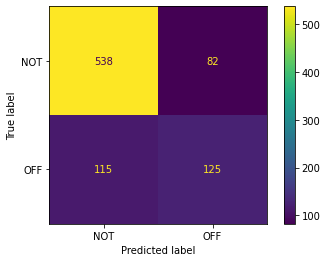

In [ ]:
generate_output_file('gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/ClassicModel/test_IN.csv')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


CPU times: user 5.5 s, sys: 31.1 ms, total: 5.53 s
Wall time: 27.4 s
Accuracy: 62.63463131731566%
              precision    recall  f1-score   support

         NOT       0.64      0.73      0.68       664
         OFF       0.60      0.50      0.54       543

    accuracy                           0.63      1207
   macro avg       0.62      0.61      0.61      1207
weighted avg       0.62      0.63      0.62      1207

Confusion Matrix for test_OUT1: 
[[487 177]
 [274 269]]


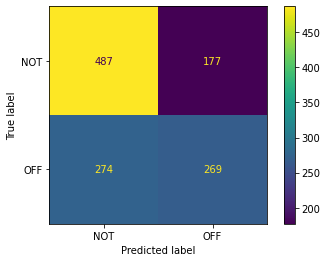

In [ ]:
generate_output_file('gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/ClassicModel/test_OUT1.csv')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


CPU times: user 5.53 s, sys: 35.5 ms, total: 5.56 s
Wall time: 27.4 s
Accuracy: 82.08333333333333%
              precision    recall  f1-score   support

         NOT       0.82      0.82      0.82       600
         OFF       0.82      0.82      0.82       600

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200

Confusion Matrix for test_OUT2: 
[[491 109]
 [106 494]]


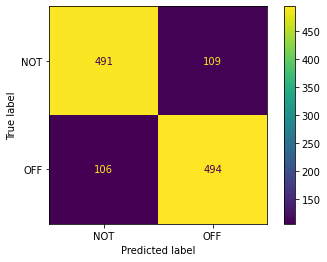

In [ ]:
generate_output_file('gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/ClassicModel/test_OUT2.csv')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


CPU times: user 5.56 s, sys: 48.6 ms, total: 5.61 s
Wall time: 27.6 s
Accuracy: 61.28526645768025%
              precision    recall  f1-score   support

         NOT       0.89      0.63      0.73      1088
         OFF       0.20      0.54      0.29       188

    accuracy                           0.61      1276
   macro avg       0.54      0.58      0.51      1276
weighted avg       0.79      0.61      0.67      1276

Confusion Matrix for test_TEXTGAIN: 
[[681 407]
 [ 87 101]]


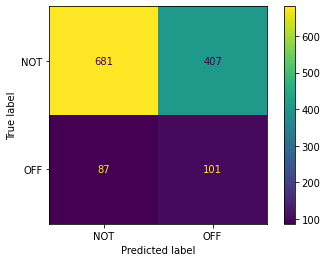

In [ ]:
generate_output_file('gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/ClassicModel/test_TEXTGAIN.csv')